# Simulation de variable aléatoire 

## Méthode basée sur l'inverse généralisée

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm
from math import *

In [2]:
Lambda = 2
f = lambda x : Lambda * np.exp(-Lambda * x)
F = lambda x : 1 - np.exp(-Lambda * x)
invF = lambda u : -(1/Lambda)* np.log(1 - u)

nbEchan =  10000

def Inverse_generalisee(invF, nbEchan):
    '''Méthode de l'inverse généralisée
    
    Returns: Echantillons (array de taille nbEchan)
    '''
    U = uniform.rvs(loc = 0, scale = 1, size = nbEchan)
    X = invF(U)
    return X

X = Inverse_generalisee(invF, nbEchan)


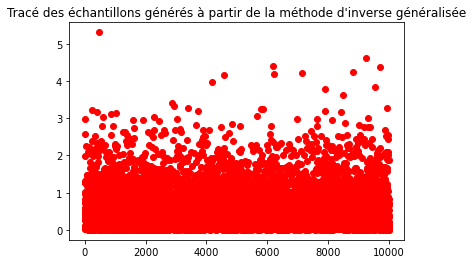

In [3]:
plt.plot(X, 'ro')
plt.title("Tracé des échantillons générés à partir de la méthode d'inverse généralisée")
plt.show()

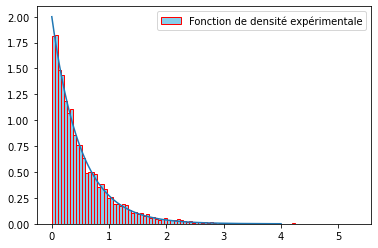

In [4]:
plt.hist(X, bins = 100, density = True, color = 'skyblue', edgecolor = "red", label = "Fonction de densité expérimentale")
x = np.linspace(0, 4, nbEchan)
f = f(x)
plt.plot(x, f)
plt.legend()
plt.show()

Principal inconvénient de cette méthode :  
Il faut pouvoir écrire l'inverse de la fonction de répartition ! Et ce n'est pas toujours possible. 

## Méthode Accept Reject


In [5]:
from scipy.stats import norm, cauchy

In [6]:
nbEchan = 10000
M = 5
X = np.zeros(shape = nbEchan)

In [7]:
f = lambda x : norm.pdf(x = x, loc = 0, scale = 1) #scale = écart type

for i in range(nbEchan):
    u = uniform.rvs(loc = 0, scale = 1, size = 1)
    x = cauchy.rvs(loc = 0, scale = 1, size = 1)
    
    while (f(x) / (M * cauchy.pdf(x= x, loc = 0, scale = 1))) < u:
        u = uniform.rvs(loc = 0, scale = 1, size = 1)
        x = cauchy.rvs(loc = 0, scale = 1, size = 1)
    X[i] = x

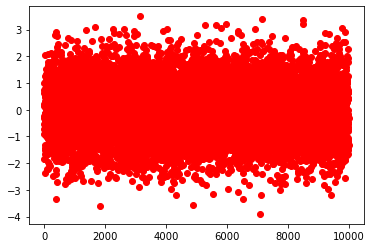

In [8]:
plt.plot(X, 'ro')
plt.show()

Faire varier M pour voir comment l'algorithme réagit. D'autre part, l'algorithme fonctionne quelques fois 'pour rien', jeter un oeil à la boucle while.. 

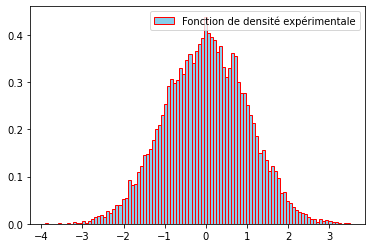

In [9]:
plt.hist(X, bins = 100, density = True, color = 'skyblue', edgecolor = "red", label = "Fonction de densité expérimentale")

plt.legend()
plt.show()

##  Méthode de Box-Muller pour des lois normales univariées

In [39]:
def BoxMuller(N, u1f, u2f):
    simul = np.array([(0., 0.) for _ in range(N)])
    for i in range(N):
        u1 = u1f.rvs(size = 1)
        u2 = u2f.rvs(size = 1)
        R = -2*log(u1)
        V = 2*pi*u2
        z1 = sqrt(R)*cos(V)
        z2 = sqrt(R)*sin(V)
        
        simul[i] = (z1, z2)
    return simul

In [52]:
u1f = uniform()
u2f = uniform()
X_BM = BoxMuller(10000//2, u1f, u2f)

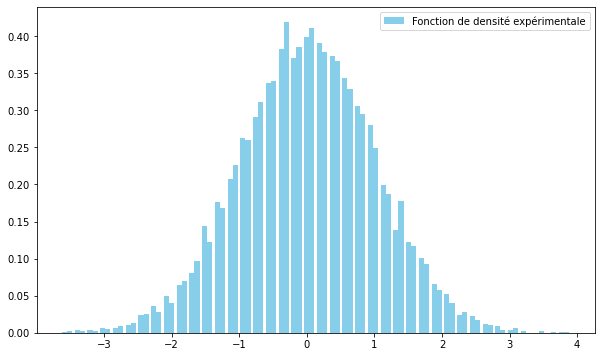

In [53]:
plt.figure(figsize = (10, 6))
plt.hist(X_BM, bins = 40, density = True, color = ['skyblue', 'skyblue'], label = "Fonction de densité expérimentale")

plt.legend()
plt.show()

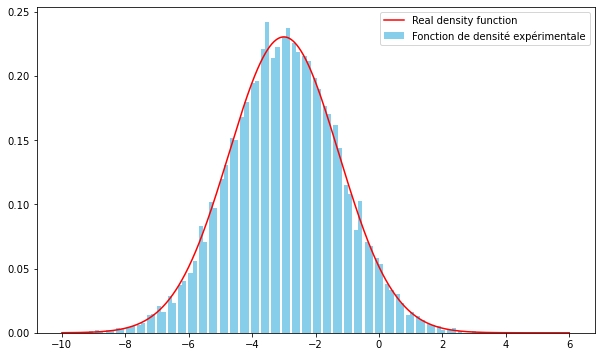

In [68]:
#Génération de 5000 échantillons à partir des échantillons précédents 
#Loi normale de moyenne 3 et d'écart-type 3
new_X = X_BM*(sqrt(3))-3

plt.figure(figsize = (10, 6))
plt.hist(new_X, bins = 40, density = True, color = ['skyblue', 'skyblue'], label = "Fonction de densité expérimentale")
plt.plot(np.linspace(-10, 6, 5000), norm.pdf(np.linspace(-10, 6, 5000), loc = -3, scale = np.sqrt(3)), 'r', label = 'Real density function')
plt.legend()
plt.show()

## Echantillonage à partir d'une loi normale multivariée 

In [77]:
def NMulti(mu, sigma, n):
    u1f = uniform()
    u2f = uniform()
    simulBM = np.array(BoxMuller(n//2, u1f, u2f))
    A = np.linalg.cholesky(sigma)
    print(A)
    return mu + np.dot(A, simulBM)

In [78]:
mu = np.array([0, 50, 100, 50, 100, 200])
sigma = np.array([[11, 10, 5, 9, 4, 2], [10, 13, 9, 15, 5, 3], [5, 9, 15, 11, 3, 1], [9, 15, 11, 21, 6, 4], [4, 5, 3, 6, 5, 1], [2, 3, 1, 4, 1, 1]])
NMulti(mu, sigma, 1000)

[[ 3.31662479  0.          0.          0.          0.          0.        ]
 [ 3.01511345  1.97714211  0.          0.          0.          0.        ]
 [ 1.50755672  2.2530224   2.76607353  0.          0.          0.        ]
 [ 2.7136021   3.44850367 -0.31107818  1.2835172   0.          0.        ]
 [ 1.20604538  0.68970073 -0.13452029  0.23917941  1.73045224  0.        ]
 [ 0.60302269  0.59774064 -0.45400599  0.12550998 -0.13327574  0.19857781]]


ValueError: shapes (6,6) and (500,2) not aligned: 6 (dim 1) != 500 (dim 0)

## Algorithme de Metropolis Hastings
### Cas où la loi de proposition est indépendante

On a donc $q(y | x_{t}) = q(y)$ 

In [40]:
def MHindep(n, chauffe, q, f):
    simul = np.array([i for i in range(n)], dtype = float)
    x0 = q.rvs(size = 1)
    y = q.rvs(size = 1)
    x = x0
    for t in range(n + chauffe + 1):
        r = (f.pdf(y)*q.pdf(x))/(f.pdf(x)*q.pdf(y))
        rho = min(1, r)
        
        u = uniform.rvs(size = 1)
        if u < rho:
            x = y
        if t > chauffe:
            simul[t - chauffe - 1] = x
        y = q.rvs(size = 1)
    return simul

In [54]:
nbEchant = 20000
nbChauffe = 500

q = uniform(loc = -10, scale = 20) #loi de proposition
f = norm(loc = 0, scale = 1) #loi cible (normale)

sim_1 = MHindep(nbEchant, nbChauffe, q, f)

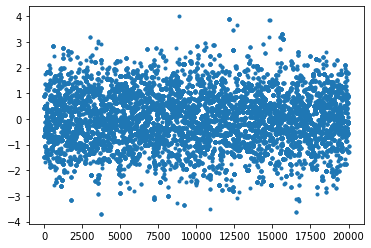

In [55]:
plt.plot(sim_1, '.')

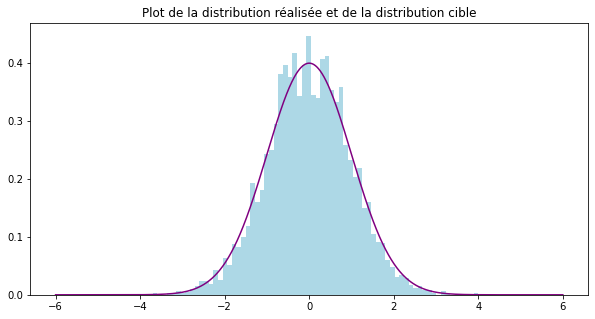

In [64]:
plt.figure(figsize = (10, 5))
plt.hist(sim_1,bins = 70, density = True, color = 'lightblue')
xvalues = np.linspace(-6, 6, 20000)
plt.plot(xvalues, f.pdf(xvalues), color = 'purple')
plt.title("Plot de la distribution réalisée et de la distribution cible")
plt.show()

In [58]:
min(sim_1)

-3.7009549788074043

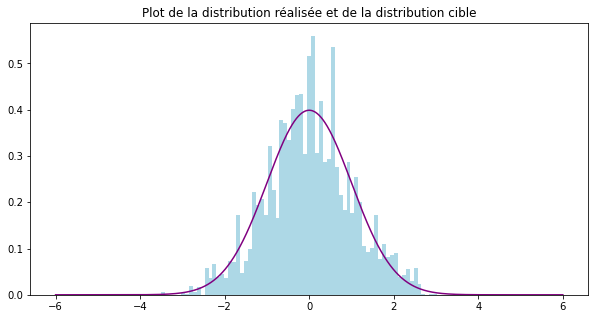

In [69]:
#Changement des valeurs de BurIn et de loi de proposition

qbis = uniform(loc = -40, scale = 80)
nbChauffe2 = 1000

sim_2 = MHindep(nbEchant, nbChauffe, qbis, f)

plt.figure(figsize = (10, 5))
plt.hist(sim_2, bins = 70, density = True, color = 'lightblue')
xvalues = np.linspace(-6, 6, 20000)
plt.plot(xvalues, f.pdf(xvalues), color = 'purple')
plt.title("Plot de la distribution réalisée et de la distribution cible")
plt.show()

Si on augmente le nombre de BurnIn on s'assure d'une meilleure convergence. En revanche, si le nombre de BurnIn est inchangé mais on utilise une loi uniforme sur un intervalle plus grand, on voit que la 'convergence' est plus lente et que la simulation est moins précise. 

### Algorithme en utilisant une loi de Laplace

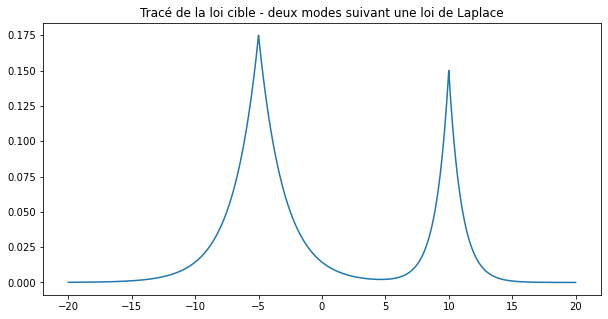

In [89]:
a1 = 1
a2 = 2
mu1 = 10
mu2 = -5
p = 0.3

f = lambda x: p*(1/(2*a1))*exp(-np.linalg.norm((x - mu1)/ a1)) + (1/(2*a2))*exp(-np.linalg.norm((x - mu2)/ a2))*(1 - p)

x = np.linspace(-20, 20, 20000)
y = np.array([f(i) for i in x])

plt.figure(figsize = (10, 5))
plt.plot(x, y)
plt.title("Tracé de la loi cible - deux modes suivant une loi de Laplace")
plt.show()

In [114]:
n = 20000
chau = 1000

fbis = f
q2 = norm

In [123]:
def MHindep2Modes(n, chauffe, q, f):
    simul = np.array([i for i in range(n)], dtype = float)
    x0 = q.rvs(loc = 0, scale = 10)
    y = q.rvs(loc = 0, scale = 10)
    x = x0
    for t in range(n + chauffe + 1):
        r = (f(y)*q1.pdf(x))/(f(x)*q1.pdf(y))
        rho = min(1, r)
        
        u = uniform.rvs(size = 1)
        if u < rho:
            x = y
        if t > chauffe:
            simul[t - chauffe - 1] = x
        y = q.rvs(loc = 0, scale = 10)
    return simul

In [124]:
sim_3 = MHindep2Modes(n, chau, q2, fbis)

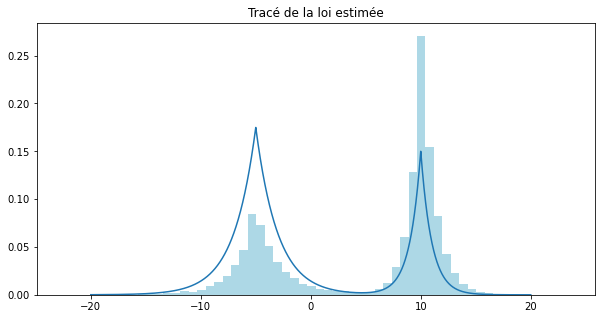

In [125]:
x = np.linspace(-20, 20, 20000)
y = np.array([f(i) for i in x])

plt.figure(figsize = (10, 5))
plt.plot(x, y)
plt.hist(sim_3, bins = 60, density = True, color = "lightblue")
plt.title("Tracé de la loi estimée")
plt.show()